# Conic Formulation of Unbalanced GW

Implement the bi-linear programming formulation of unbalanced Gromov-Wasserstein.

_Warning:_ you need to install `progressbar2` apparently with `pip install progressbar2`. 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import progressbar as pb

In [2]:
def distmat(x,y):
    return np.sqrt( np.abs(np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y) ) )

# Unbalanced Gromov-Wasserstein

In [3]:
n = 6
m = 5
k = 10 # angle samples
l = 11 

In [4]:
normalize = lambda a: a/np.sum(a)
# random histograms
a = normalize(np.random.rand(n))
b = normalize(np.random.rand(m))
d = 2 # dimension
x = np.random.rand(d,n)
y = np.random.rand(d,m)

In [5]:
DX = distmat(x,x)
DY = distmat(y,y)

Discretized radius on the cones. TODO: select wisely `rmax`

In [6]:
rmax = np.sqrt( np.max(a) )
smax = np.sqrt( np.max(b) )
R = np.linspace(0,rmax,k)
S = np.linspace(0,smax,l)

Compute the GW kernel 
$$
    K(x,r,x',r',y,s,y',s') 
    \triangleq (rr')^2 + (ss')^2 - 2 r's' e^{ - |D_X(x,x')-D_Y(y,y')|^2 /\tau }
$$

In [7]:
tau = 1
def GH(x,r,y,s): return r**2+s**2 - 2*r*s*np.exp( -np.abs(x-y)**2/(2*tau) )
# form the 8D kernel (x,r,x',r' ; y,s, y',s')
K = GH( DX[:,None,:,None, None,None,None,None], \
        R[None,:,None,None, None,None,None,None]*R[None,None,None,:, None,None,None,None], \
        DY[None,None,None,None, :,None,:,None], \
        S[None,None,None,None, None,:,None,None]*S[None,None,None,None, None,None,None,:])
# operator to apply K to a matching alpha, i.e. compute K*alpha
def apply_K(alpha):
    return np.sum( K * alpha[None,None,:,:, None,None,:,:], (2,3,6,7), keepdims=True ).squeeze()
# test
Alpha = np.random.rand( n,k, m,l )
apply_K(Alpha).shape

(6, 10, 5, 11)

Solve the conic GW problem, which is a bilinear non-convex problem, by alernating minimization
$$
    \min_{\alpha \geq 0} \{
        \langle K \alpha, \alpha \rangle
        :
        \sum_{k,j,\ell} \alpha_{i,k,j,l} r_{k}^2 = a_i, 
        \sum_{i,k,\ell} \alpha_{i,k,j,l} s_{\ell}^2 = b_j.         
        \}
$$

In [8]:
# CVXPY problem setup 
RR = np.tile(R, (n,1))
SS = np.tile(S, (m,1))
# variable
alpha = cp.Variable((n*k,m*l))
alpha1 = cp.Variable((n,k))
alpha2 = cp.Variable((m,l))
# constraints
U = [0 <= alpha, 
        alpha1==cp.reshape(cp.sum(alpha, axis=1),(k,n)).T, \
        alpha2==cp.reshape(cp.sum(alpha, axis=0),(l,m)).T, \
        cp.sum( cp.multiply(alpha1, RR**2), 1)==a, \
        cp.sum( cp.multiply(alpha2, SS**2), 1)==b \
    ]

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


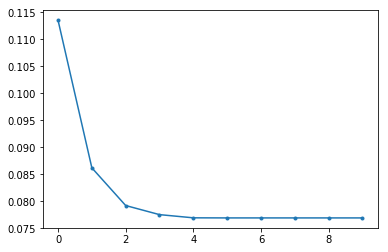

In [14]:
# initialize matching
Alpha = np.random.rand( n,k, m,l )
Alpha = Alpha / np.sum(Alpha.flatten())
# alternate minimization
niter = 10
GWcost = np.zeros(niter)
for it in pb.progressbar(range(niter)):
    C = apply_K(Alpha).reshape(n*k,m*l)
    # solve using CVXPY
    objective = cp.Minimize( cp.sum(cp.multiply(alpha,C)) )
    prob = cp.Problem(objective, U)
    result = prob.solve(verbose=False)
    Alpha = alpha.value.reshape(n,k,m,l)
    GWcost[it] = np.sum( apply_K(Alpha).flatten() * Alpha.flatten() )
plt.plot(GWcost, '.-')

TODO: find a way to convert a conic measure $\alpha$ into a classical GW matching $\pi$.

In [16]:
def dilation(x,r,y,s): return np.sqrt( r*s*np.exp( -abs(x-y)**2/(2*tau) ) )
# eta = dilation( R[None,:,None,None], S[None,None,None,:], D[:,None,:,None] )
# multiply by eta^2 and then marginalize on (x,y)
# pi = np.sum( np.sum( Alpha * eta**2, 1, keepdims=True), 3, keepdims=True).squeeze()
# plt.imshow(pi)